# Unleashing the Power of Cognitive Learning for Brain Tumour Diagnosis

## Importing Libraries

In [1]:
!pip install neuralintents

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from neuralintents.assistants import BasicAssistant
import nltk

nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


2024-04-02 14:11:56.809741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 14:11:56.809794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 14:11:56.811400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Dataset Preparation

In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 131.01it/s]


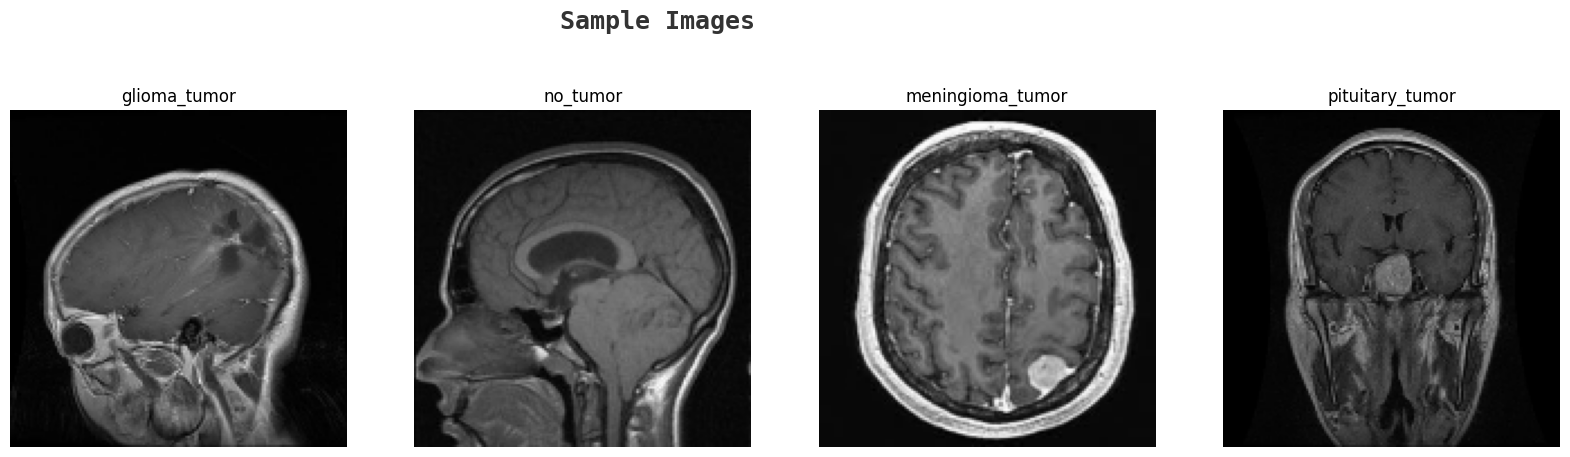

In [3]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Images',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

## Data Preprocessing

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101,stratify=y_train)

In [6]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
y_train_to_plot=y_train
y_test_to_plot=y_test

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## Model Training

In [8]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [9]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [10]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [11]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs = 30, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30


2024-04-02 14:23:41.590796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1712067825.927080    1616 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.7682
Epoch 1: val_accuracy improved from -inf to 0.15870, saving model to effnet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 54s 214ms/step - loss: 0.5962 - accuracy: 0.7682 - val_loss: 1.8690 - val_accuracy: 0.1587 - lr: 0.0010
Epoch 2/30
66/66 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.9061
Epoch 2: val_accuracy did not improve from 0.15870
66/66 [==============================] - 9s 131ms/step - loss: 0.2823 - accuracy: 0.9061 - val_loss: 2.7609 - val_accuracy: 0.1587 - lr: 0.0010
Epoch 3/30
66/66 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9310
Epoch 3: val_accuracy did not improve from 0.15870

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
66/66 [==============================] - 9s 131ms/step - loss: 0.2074 - accuracy: 0.9310 - val_loss: 6.7840 - val_accuracy: 0.1587 - lr: 0.0010
Epoch 4/30
66/66 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9650
Epoch 4: val_accuracy did not improve from 0.15870
66/66 [==============================] - 9s 132ms/step 

In [12]:
model.load_weights('./effnet.h5')

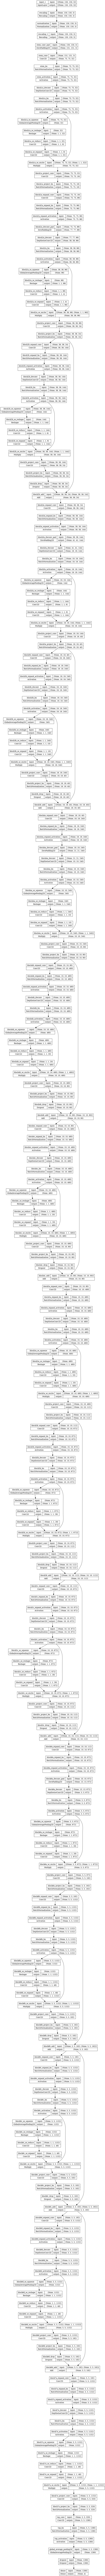

In [13]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

## Testing Performance

### Graphs

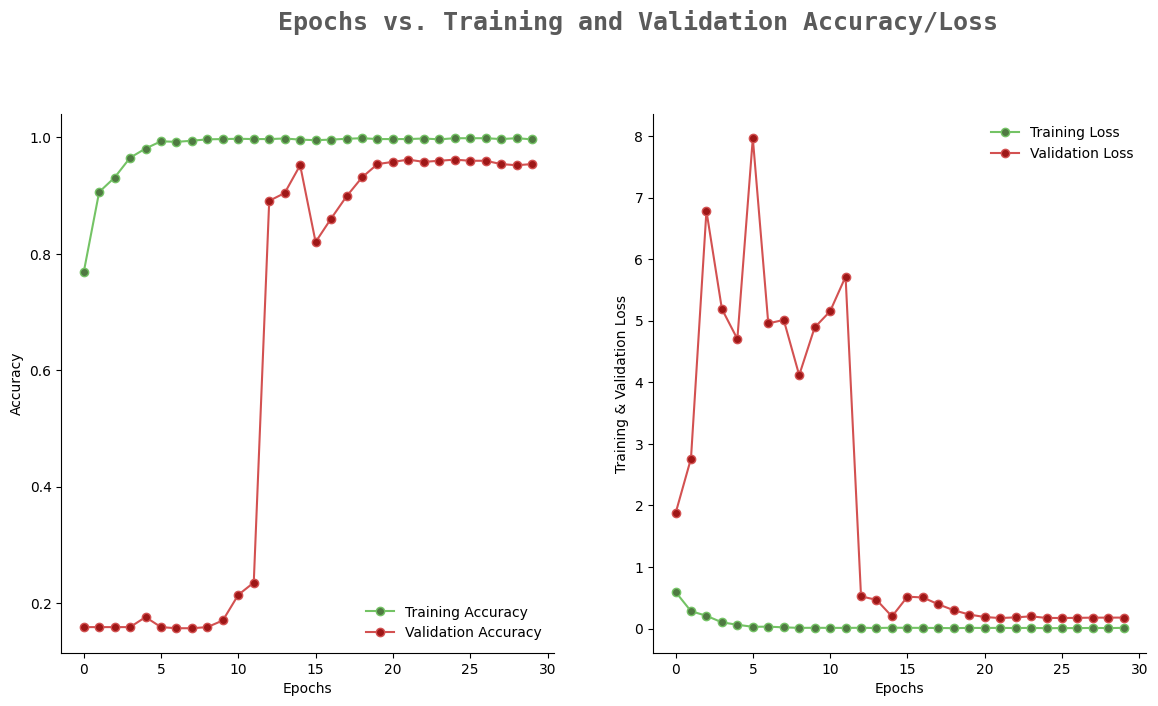

In [15]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

filterwarnings('ignore')

epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']


fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

### Classification Report

In [16]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 3s 89ms/step


In [17]:
print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       185
           1       1.00      0.98      0.99       100
           2       0.94      0.91      0.93       188
           3       0.94      0.99      0.97       180

    accuracy                           0.95       653
   macro avg       0.96      0.95      0.96       653
weighted avg       0.95      0.95      0.95       653



### Confusion Matrix

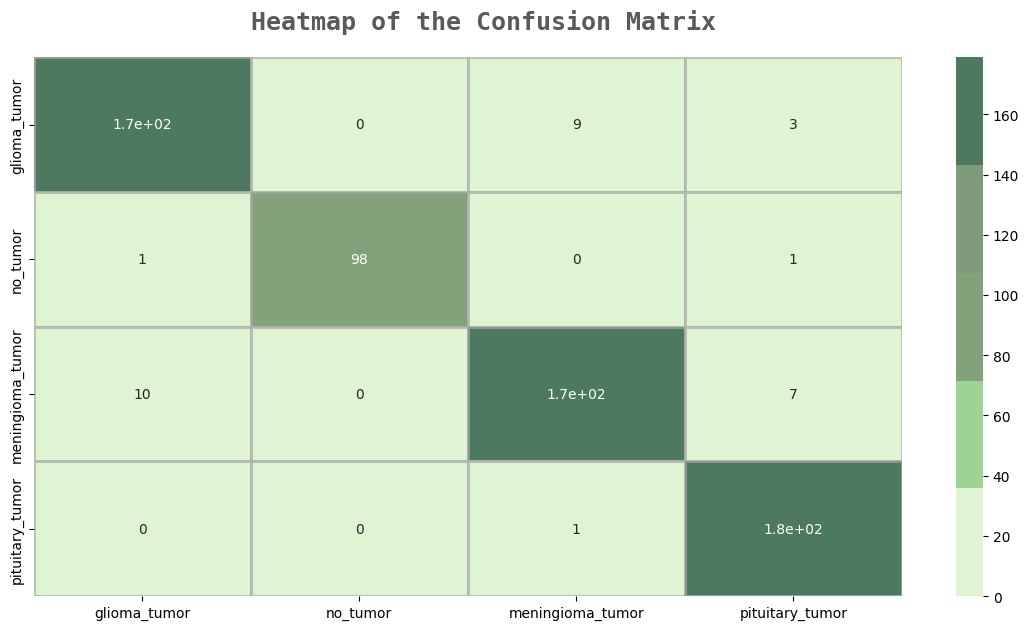

In [18]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

### Testing with sample images

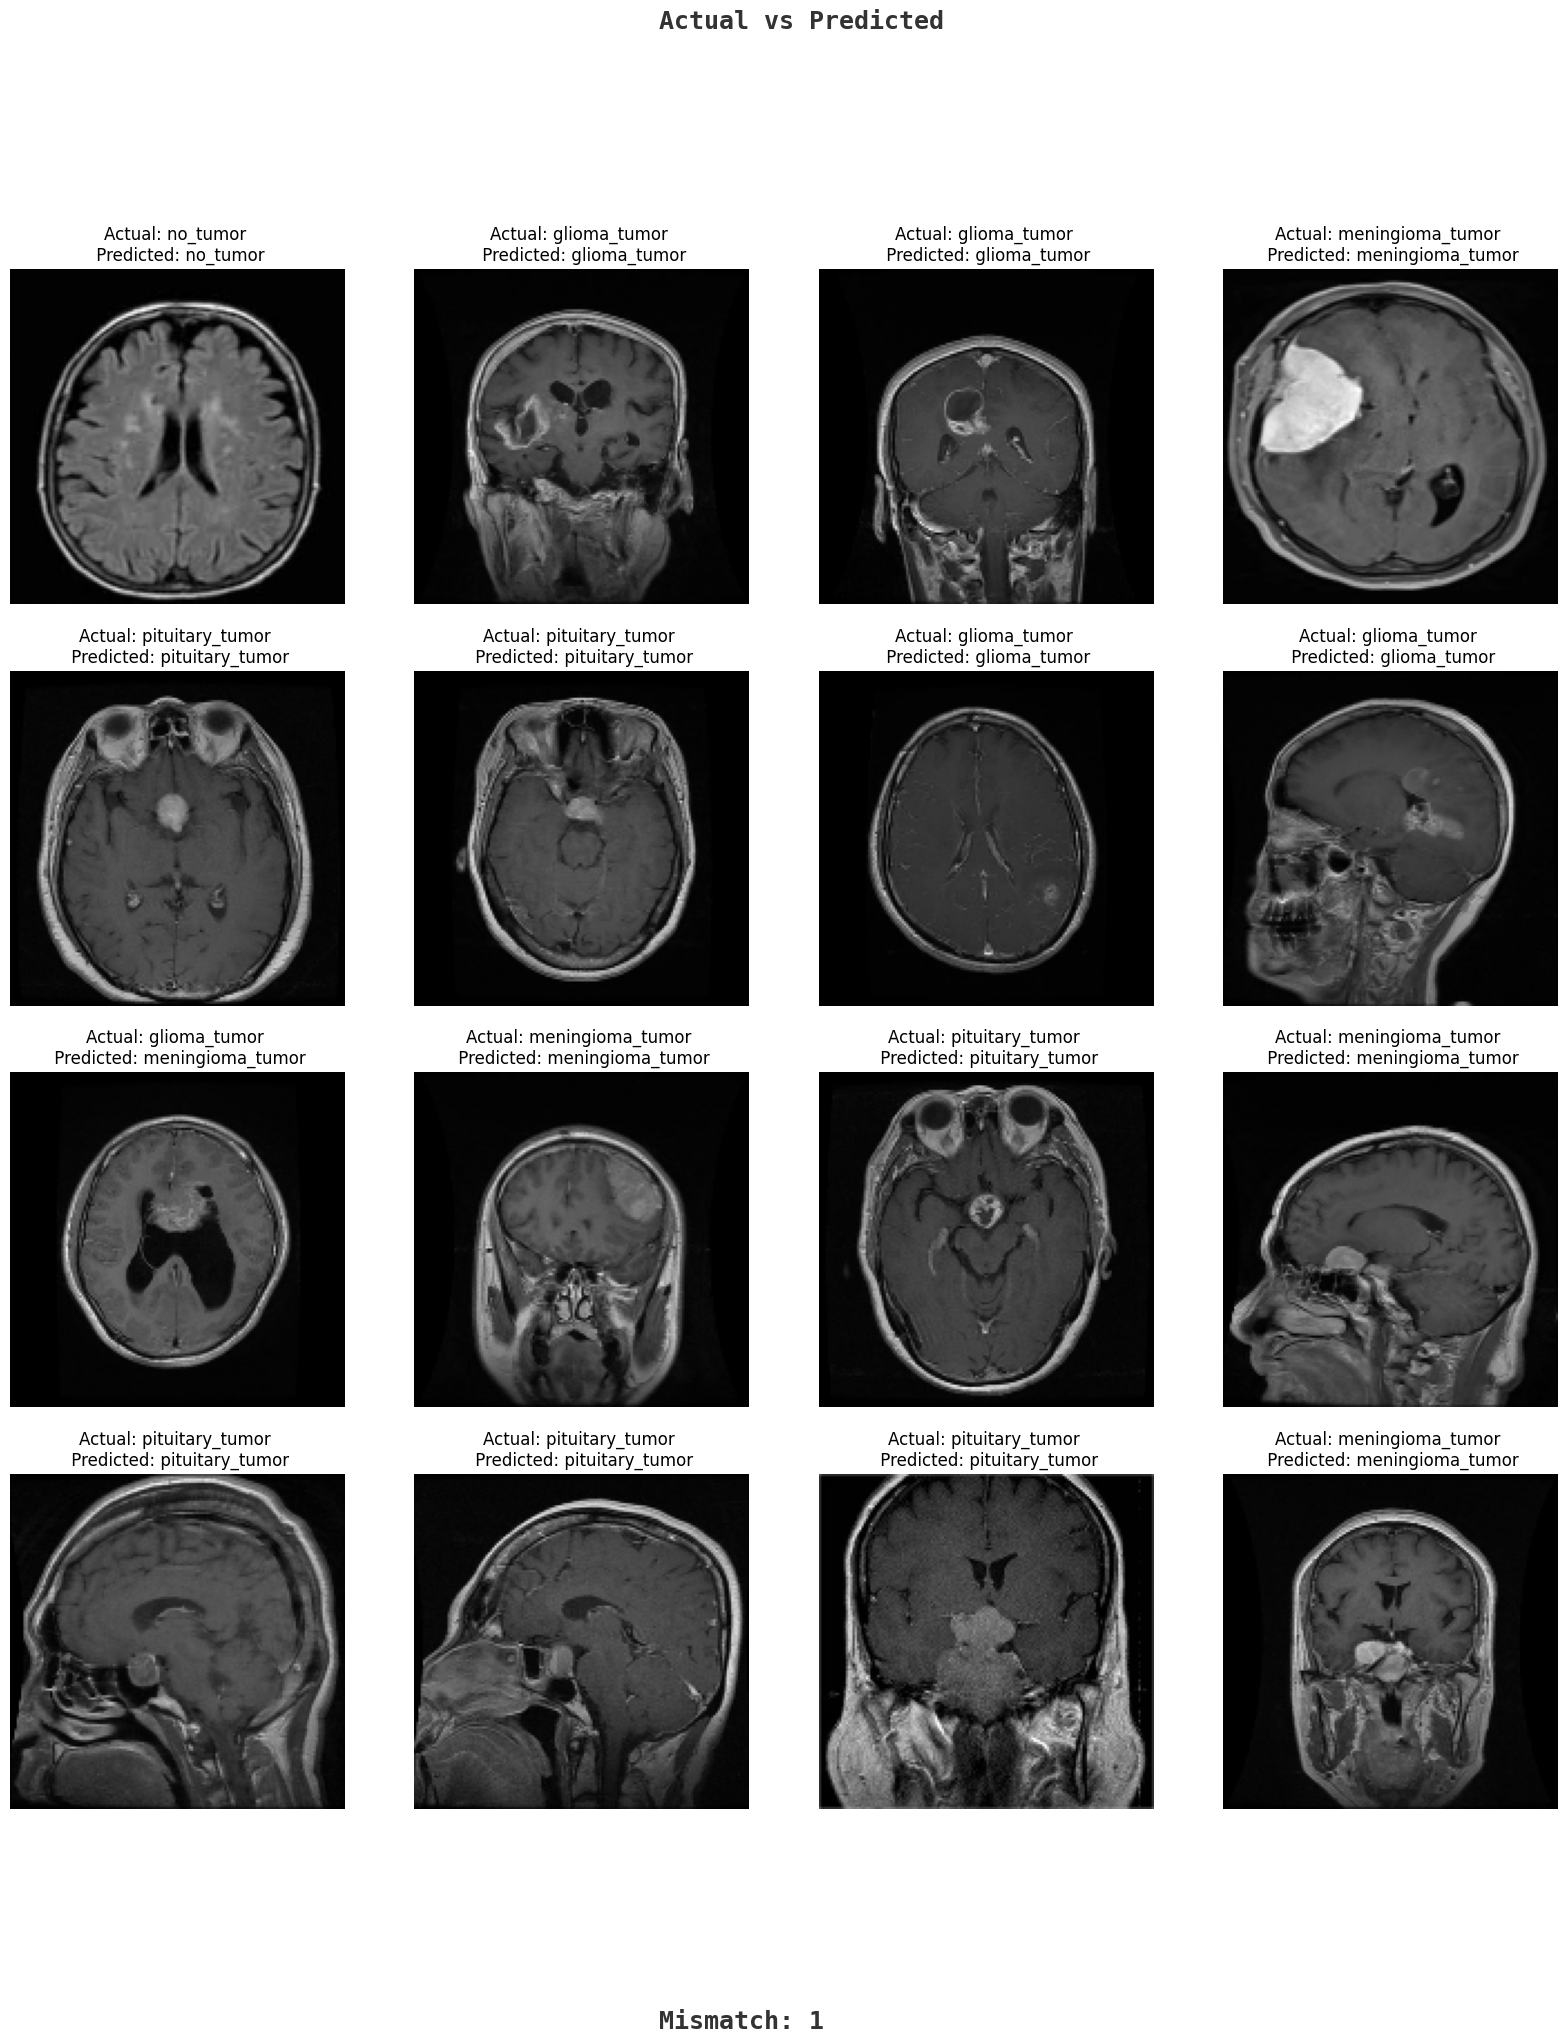

In [19]:
k = 0
mismatch=0
fig, ax = plt.subplots(4, 4, figsize=(20, 20)) 
fig.text(s='Actual vs Predicted', size=18, fontweight='bold',
         fontname='monospace', y=1, x=0.45, alpha=0.8)

for i in range(16):
    ax[k // 4, k % 4].imshow(X_test[i])
    ax[k // 4, k % 4].set_title(f"Actual: {y_test_to_plot[i]} \n Predicted: {labels[pred[i]]}")
    ax[k // 4, k % 4].axis('off')
    k += 1
    if y_test_to_plot[i]!=labels[pred[i]]:
        mismatch+=1
        
fig.text(s=f"Mismatch: {mismatch}", size=18, fontweight='bold',
         fontname='monospace', y=0, x=0.45, alpha=0.8)

plt.show()


## Integrated System for Cognitive Learning

### Prediction using MRI Scans

In [20]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    print(p)
    print(np.argmax(p,axis=1))
    p = np.argmax(p,axis=1)[0]
    
    prediction = labels[p]

    if p==0:
        p='Glioma Tumor'
    elif p==2:
        p='Meningioma Tumor'
    elif p==1:
        prediction = 'No Tumor'
    else:
        p='Pituitary Tumor'

    if p!=2:
        p = f'The Model predicts that it is a {p}'

    return prediction, p

In [21]:
# Making Widget for uploading photos and predicting

uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='PREDICT IT')
out = widgets.Output()
predicted_tumor={"tumor":''}
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            prediction, _ = img_pred(uploader)
            print(_)
            # Set the context based on the predicted tumor type
            if prediction!='no_tumor':
                predicted_tumor["tumor"]=prediction.split('_')[0]
            else:
                predicted_tumor["tumor"]=prediction
        except:
            print('No Image Uploaded/Invalid Image File')
    
button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')

### Chatbot Integration

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

own_layers = [
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5)
]

if (predicted_tumor["tumor"]!='no_tumor'):
    intents=f"../input/intents/{predicted_tumor['tumor']}_intents.json"
else:
    intents="../input/intents/common_intents.json"
    
assistant = BasicAssistant(intents, hidden_layers=own_layers, model_name=predicted_tumor["tumor"])

if os.path.exists(f'{predicted_tumor["tumor"]}.keras'):
    assistant.load_model()
else:
    assistant.fit_model(epochs=50)
    assistant.save_model()

assistant.model.summary()

done = False

print(f"Hey, hope you are having a good day. Based on your MRI scans, you have been diagnosed with {predicted_tumor['tumor']}. Feel free to ask any questions regarding the same.")

while not done:
    message = input("Enter a message: ")
    if message == "STOP":
        done = True
    else:
        print(assistant.process_input(message))